In [1]:
import pandas as pd
import os
import pytz

In [2]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [23]:
top_one_df = pd.read_parquet('/content/drive/MyDrive/data/one_time_buyers_all_events.parquet')

### 카테고리 3 결측치 처리

In [4]:
# category_lvl3가 결측치인 경우 category_lvl2로 대체
top_one_df['category_lvl3'] = top_one_df['category_lvl3'].fillna(top_one_df['category_lvl2'])

In [7]:
top_one_df

,event_type,product_id,category_id,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,weekday
0,view,3701244,2053013565983425517,elenberg,33.44,515535834,d90a6f2f-0d0f-47cf-9fe9-62db93dffdb9,2019-10-01,5,appliances,environment,vacuum,None,Tuesday
1,view,3600575,2053013563810775923,hotpoint-ariston,275.37,554754045,bd0302ef-c5ca-4b6a-b916-95cc2840c72c,2019-10-01,5,appliances,kitchen,washer,None,Tuesday
2,view,1004870,2053013555631882655,samsung,286.86,516489361,7d6d03fb-39d6-4143-8694-981a550acaaa,2019-10-01,5,electronics,smartphone,smartphone,None,Tuesday
3,view,27700113,2053013560086233771,leo,48.90,515630204,f9cc0313-5572-4894-a4eb-45d855f064cc,2019-10-01,5,construction,tools,pump,None,Tuesday
4,view,3900774,2053013552326770905,artel,72.85,513664804,c0177eae-2279-4b2f-8bf7-e9837cc0612a,2019-10-01,5,appliances,environment,water_heater,None,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28371233,purchase,6800658,2053013555220840837,kingston,53.77,624595867,f71468a4-7ca7-453b-954f-f5e72cba556a,2020-03-31,23,appliances,kitchen,juicer,None,Tuesday
28371234,view,1005098,2232732093077520756,samsung,145.18,634646276,41e61625-2646-4b06-b9b0-9b4cc13c9959,2020-03-31,23,construction,tools,light,None,Tuesday
28371235,view,5800861,2232732082390433922,kicx,36.55,628330088,ad624635-dd1b-480a-867a-2fda5c0a23a2,2020-03-31,23,electronics,audio,subwoofer,None,Tuesday
28371236,view,100039953,2232732099754852875,kivi,257.12,549607680,d92aa32a-2a69-4d97-8259-352bd181806a,2020-03-31,23,appliances,personal,massager,None,Tuesday


# 분석 목표:
고객 재구매 유도 통한 고객 리텐션 향상

데이터 분석 목표: 1회 구매자 vs 2회 이상 구매자 나누어 분석 후, 재구매 요인 분석과 재구매 유도 방안 도출 (재구매하는 안 하는 이유와 재구매하는 이유 분석)

# 카테고리 레벨3별 전환 퍼널 분석(전환율)

In [ ]:
# 1. 이벤트별 필터링
views = top_one_df[top_one_df['event_type'] == 'view']
carts = top_one_df[top_one_df['event_type'] == 'cart']
purchases = top_one_df[top_one_df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    top_one_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))

       product_id  category_lvl3  view_to_cart_rate  cart_to_purchase_rate  \
37915    15200839         toster           0.295455               0.538462   
37885    15200572         toster           0.333333               0.470588   
70323   100018745      microwave           0.171429               0.833333   
56148    26006262          light           0.203125               0.692308   
75957   100056052       massager           0.266667               0.500000   
83104   100104689  refrigerators           0.187500               0.666667   
37871    15200498         toster           0.187500               0.666667   
88191   100138729       massager           0.156863               0.750000   
37923    15200879         toster           0.205882               0.571429   
40905    18000200        welding           0.383333               0.304348   

       view_to_purchase_rate  
37915               0.159091  
37885               0.156863  
70323               0.142857  
56148            

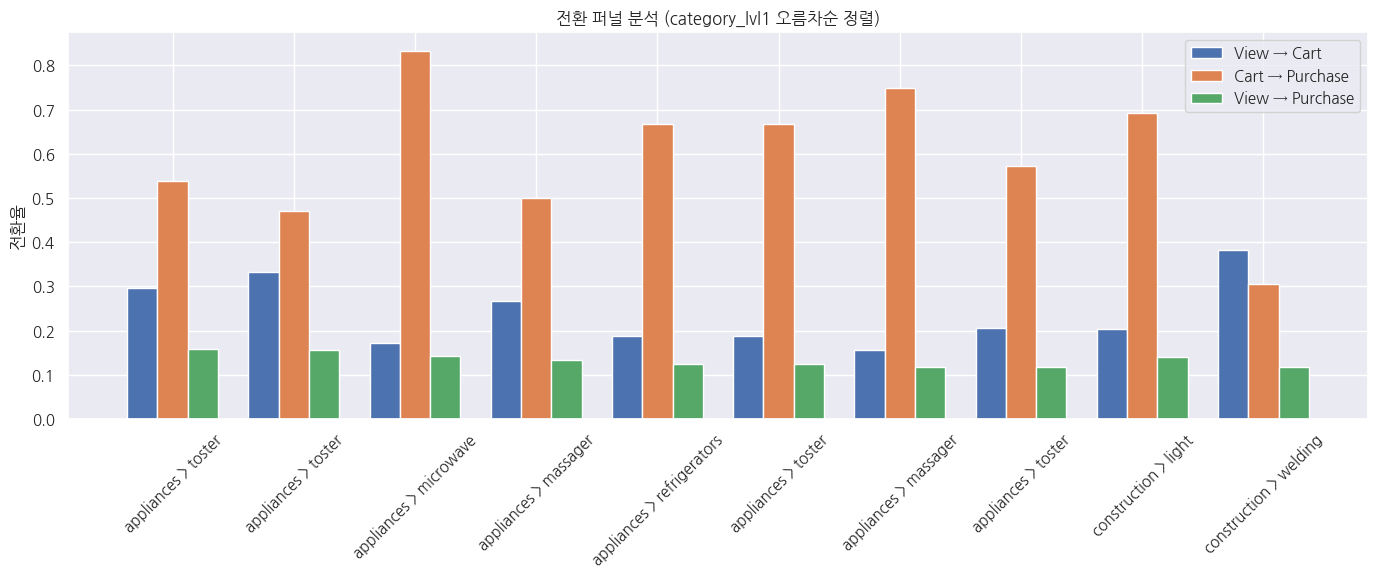

In [ ]:
# 1. 새로운 라벨 컬럼 생성
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()


| 카테고리                           | View→Cart                      | Cart→Purchase                                  | View→Purchase                           | 인사이트 |
| ------------------------------ | ------------------------------ | ---------------------------------------------- | --------------------------------------- | ---- |
| **appliances > toster**        | 꾸준히 높은 퍼널 흐름 유지                | **50% 이상 전환**                                  | 전반적으로 안정적인 전환 → **리텐션 캠페인 최적 타겟**       |      |
| **appliances > microwave**     | 낮은 View→Cart (관심 적음)           | **매우 높은 Cart→Purchase (\~83%)**                | 초고의사 결정력 → **전면 배치/추천 강화** 전략 필요        |      |
| **appliances > massager**      | 꾸준히 등장하나 View→Purchase 낮음      | 감성소비 상품 → **후기/사용 영상** 중심 캠페인 적합               |                                         |      |
| **appliances > refrigerators** | 낮은 전반 흐름                       | 고가 & 비교 제품 특성 → **긴 구매 주기**, **리타겟팅 중심 전략** 필요 |                                         |      |
| **construction > light**       | View→Cart 낮지만 Cart→Purchase 높음 | 비교적 빠른 전환 → **구매 의도 있는 고객에게 맞춤 쿠폰 효과적**        |                                         |      |
| **construction > welding**     | View→Cart 매우 높음 (**1위**)       | 하지만 Cart→Purchase 급락                           | 가격/정보 부족 추정 → **가격 장벽 해소, 상세 설명 보강 필요** |      |


/tmp/ipython-input-3140970662.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  )['to_cart'].fillna(False).astype(bool)
/tmp/ipython-input-3140970662.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  )['to_purchase'].fillna(False).astype(bool)
/tmp/ipython-input-3140970662.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  )['to_p

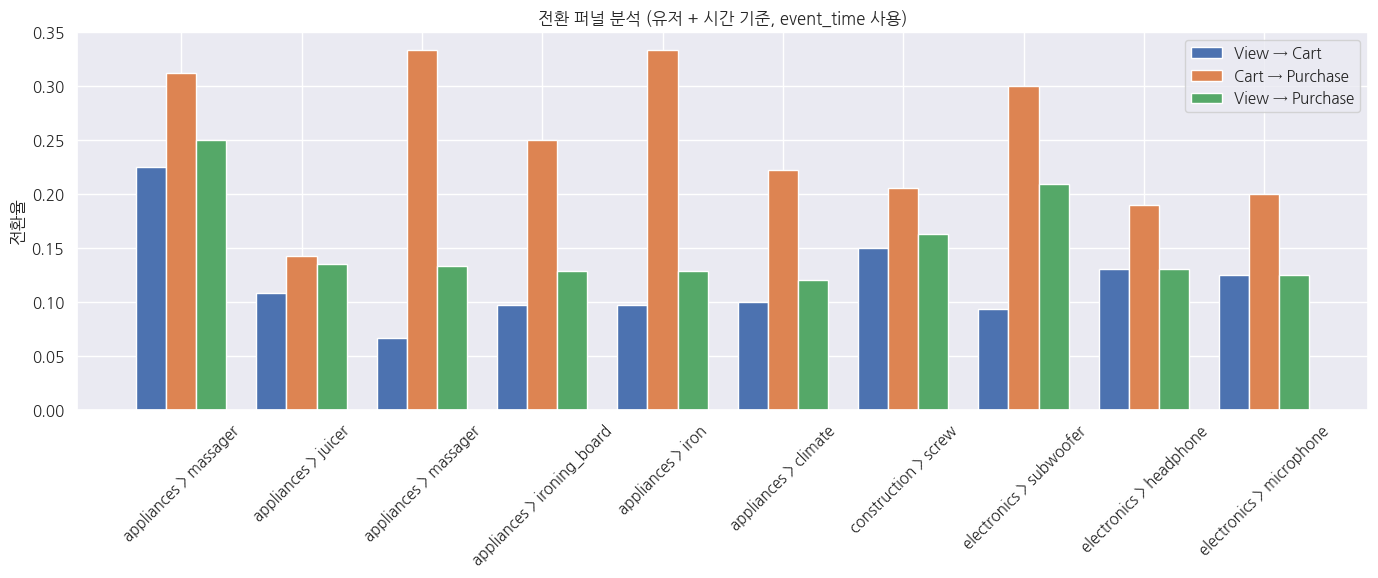

In [17]:
# 0. event_time 생성
top_one_df['event_time'] = pd.to_datetime(top_one_df['event_date']) + pd.to_timedelta(top_one_df['event_hour'], unit='h')

# 1. 이벤트별 첫 이벤트 기준 추출
views = top_one_df[top_one_df['event_type'] == 'view'].sort_values('event_time') \
    .groupby(['user_id', 'product_id'], as_index=False).first()
carts = top_one_df[top_one_df['event_type'] == 'cart'].sort_values('event_time') \
    .groupby(['user_id', 'product_id'], as_index=False).first()
purchases = top_one_df[top_one_df['event_type'] == 'purchase'].sort_values('event_time') \
    .groupby(['user_id', 'product_id'], as_index=False).first()

# 2. view → cart
view_cart = pd.merge(views, carts, on=['user_id', 'product_id'], suffixes=('_view', '_cart'))
view_cart = view_cart[view_cart['event_time_cart'] > view_cart['event_time_view']]
converted_view_cart = view_cart[['user_id', 'product_id']].drop_duplicates()
converted_view_cart['to_cart'] = True
views['to_cart'] = views.merge(
    converted_view_cart,
    on=['user_id', 'product_id'],
    how='left'
)['to_cart'].fillna(False).astype(bool)
view_to_cart_rate = views.groupby('product_id')['to_cart'].mean().reset_index()
view_to_cart_rate.columns = ['product_id', 'view_to_cart_rate']

# 3. cart → purchase
cart_purchase = pd.merge(carts, purchases, on=['user_id', 'product_id'], suffixes=('_cart', '_purchase'))
cart_purchase = cart_purchase[cart_purchase['event_time_purchase'] > cart_purchase['event_time_cart']]
converted_cart_purchase = cart_purchase[['user_id', 'product_id']].drop_duplicates()
converted_cart_purchase['to_purchase'] = True
carts['to_purchase'] = carts.merge(
    converted_cart_purchase,
    on=['user_id', 'product_id'],
    how='left'
)['to_purchase'].fillna(False).astype(bool)
cart_to_purchase_rate = carts.groupby('product_id')['to_purchase'].mean().reset_index()
cart_to_purchase_rate.columns = ['product_id', 'cart_to_purchase_rate']

# 4. view → purchase
view_purchase = pd.merge(views, purchases, on=['user_id', 'product_id'], suffixes=('_view', '_purchase'))
view_purchase = view_purchase[view_purchase['event_time_purchase'] > view_purchase['event_time_view']]
converted_view_purchase = view_purchase[['user_id', 'product_id']].drop_duplicates()
converted_view_purchase['to_purchase'] = True
views['to_purchase'] = views.merge(
    converted_view_purchase,
    on=['user_id', 'product_id'],
    how='left'
)['to_purchase'].fillna(False).astype(bool)
view_to_purchase_rate = views.groupby('product_id')['to_purchase'].mean().reset_index()
view_to_purchase_rate.columns = ['product_id', 'view_to_purchase_rate']

# 5. 통합
product_stats = view_to_cart_rate.merge(cart_to_purchase_rate, on='product_id', how='outer')
product_stats = product_stats.merge(view_to_purchase_rate, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 6. 상품 정보 결합 및 필터링
product_info = top_one_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_stats = pd.merge(product_stats, product_info, on='product_id', how='left')
view_counts = views.groupby('product_id')['user_id'].nunique().reset_index(name='view_user_count')
product_stats = pd.merge(product_stats, view_counts, on='product_id', how='left')
product_stats_filtered = product_stats[product_stats['view_user_count'] >= 30]

# 7. 시각화
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)
top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (유저 + 시간 기준, event_time 사용)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 0. event_time 생성
notop_multi_df['event_time'] = pd.to_datetime(notop_multi_df['event_date']) + pd.to_timedelta(notop_multi_df['event_hour'], unit='h')

# 1. category별 집계 (view → cart / view → purchase)
views = notop_multi_df[notop_multi_df['event_type'] == 'view']
carts = notop_multi_df[notop_multi_df['event_type'] == 'cart']
purchases = notop_multi_df[notop_multi_df['event_type'] == 'purchase']

# category label 생성
views['category_label'] = views['category_lvl1'] + ' > ' + views['category_lvl2']
carts['category_label'] = carts['category_lvl1'] + ' > ' + carts['category_lvl2']
purchases['category_label'] = purchases['category_lvl1'] + ' > ' + purchases['category_lvl2']

view_counts = views.groupby('category_label').size().reset_index(name='view_count')
cart_counts = carts.groupby('category_label').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('category_label').size().reset_index(name='purchase_count')

category_stats = view_counts.merge(cart_counts, on='category_label', how='outer')
category_stats = category_stats.merge(purchase_counts, on='category_label', how='outer')
category_stats.fillna(0, inplace=True)

category_stats['view_to_cart_rate'] = category_stats['cart_count'] / category_stats['view_count']
category_stats['view_to_purchase_rate'] = category_stats['purchase_count'] / category_stats['view_count']

# 2. cart → purchase 전환율 (user_id + category 기준)
carts_time = carts.sort_values('event_time').groupby(['user_id', 'category_label'], as_index=False).first()
purchases_time = purchases.sort_values('event_time').groupby(['user_id', 'category_label'], as_index=False).first()

cart_purchase = pd.merge(carts_time, purchases_time, on=['user_id', 'category_label'], suffixes=('_cart', '_purchase'))
cart_purchase = cart_purchase[cart_purchase['event_time_purchase'] > cart_purchase['event_time_cart']]
converted_cart_purchase = cart_purchase[['user_id', 'category_label']].drop_duplicates()
converted_cart_purchase['to_purchase'] = True

carts_time['to_purchase'] = carts_time.merge(
    converted_cart_purchase,
    on=['user_id', 'category_label'],
    how='left'
)['to_purchase'].fillna(False).astype(bool)

cart_to_purchase_rate = carts_time.groupby('category_label')['to_purchase'].mean().reset_index()
cart_to_purchase_rate.columns = ['category_label', 'cart_to_purchase_rate']

# 3. 통합
category_stats = pd.merge(category_stats, cart_to_purchase_rate, on='category_label', how='left')
category_stats.fillna(0, inplace=True)

# 4. 필터링 및 정렬
category_stats_filtered = category_stats[category_stats['view_count'] >= 30]
top_funnel_sorted = category_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (카테고리 기준 집계)')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-3805084657.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  )['to_cart'].fillna(False).astype(bool)
/tmp/ipython-input-3805084657.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  )['to_purchase'].fillna(False).astype(bool)
/tmp/ipython-input-3805084657.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  )['to_p

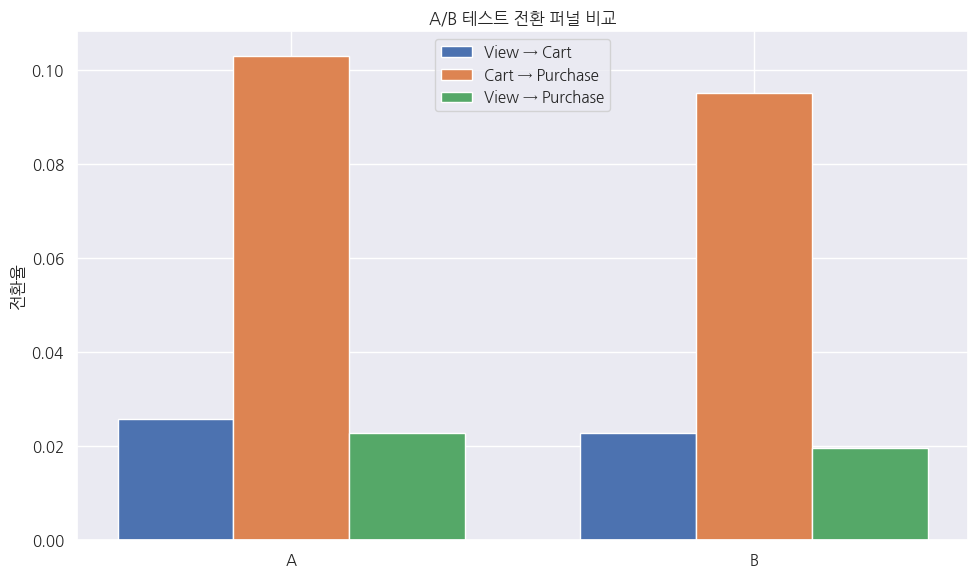

  group  view_to_cart  cart_to_purchase  view_to_purchase
0     A      0.025816          0.103107          0.022786
1     B      0.022667          0.095226          0.019492


In [26]:
# 0. event_date 형 변환
top_one_df['event_date'] = pd.to_datetime(top_one_df['event_date'])

# 1. event_time 생성 (date + hour)
top_one_df['event_time'] = pd.to_datetime(top_one_df['event_date']) + pd.to_timedelta(top_one_df['event_hour'], unit='h')

# 2. A/B 그룹 생성: 2020년 1월 1일 기준
top_one_df['experiment_group'] = top_one_df['event_date'].apply(lambda x: 'A' if x < pd.to_datetime('2020-01-01') else 'B')

# 3. 결과 저장용 리스트
group_results = []

# 4. 그룹별 퍼널 분석
for group in ['A', 'B']:
    group_df = top_one_df[top_one_df['experiment_group'] == group]

    # 이벤트별 첫 시점 추출
    views = group_df[group_df['event_type'] == 'view'].sort_values('event_time') \
        .groupby(['user_id', 'product_id'], as_index=False).first()
    carts = group_df[group_df['event_type'] == 'cart'].sort_values('event_time') \
        .groupby(['user_id', 'product_id'], as_index=False).first()
    purchases = group_df[group_df['event_type'] == 'purchase'].sort_values('event_time') \
        .groupby(['user_id', 'product_id'], as_index=False).first()

    # view → cart
    view_cart = pd.merge(views, carts, on=['user_id', 'product_id'], suffixes=('_view', '_cart'))
    view_cart = view_cart[view_cart['event_time_cart'] > view_cart['event_time_view']]
    converted_view_cart = view_cart[['user_id', 'product_id']].drop_duplicates()
    converted_view_cart['to_cart'] = True
    views['to_cart'] = views.merge(
        converted_view_cart,
        on=['user_id', 'product_id'],
        how='left'
    )['to_cart'].fillna(False).astype(bool)
    view_to_cart_rate = views['to_cart'].mean()

    # cart → purchase
    cart_purchase = pd.merge(carts, purchases, on=['user_id', 'product_id'], suffixes=('_cart', '_purchase'))
    cart_purchase = cart_purchase[cart_purchase['event_time_purchase'] > cart_purchase['event_time_cart']]
    converted_cart_purchase = cart_purchase[['user_id', 'product_id']].drop_duplicates()
    converted_cart_purchase['to_purchase'] = True
    carts['to_purchase'] = carts.merge(
        converted_cart_purchase,
        on=['user_id', 'product_id'],
        how='left'
    )['to_purchase'].fillna(False).astype(bool)
    cart_to_purchase_rate = carts['to_purchase'].mean()

    # view → purchase
    view_purchase = pd.merge(views, purchases, on=['user_id', 'product_id'], suffixes=('_view', '_purchase'))
    view_purchase = view_purchase[view_purchase['event_time_purchase'] > view_purchase['event_time_view']]
    converted_view_purchase = view_purchase[['user_id', 'product_id']].drop_duplicates()
    converted_view_purchase['to_purchase'] = True
    views['to_purchase'] = views.merge(
        converted_view_purchase,
        on=['user_id', 'product_id'],
        how='left'
    )['to_purchase'].fillna(False).astype(bool)
    view_to_purchase_rate = views['to_purchase'].mean()

    group_results.append({
        'group': group,
        'view_to_cart': view_to_cart_rate,
        'cart_to_purchase': cart_to_purchase_rate,
        'view_to_purchase': view_to_purchase_rate
    })

# 5. 결과 데이터프레임 생성
result_df = pd.DataFrame(group_results)

# 6. 시각화
plt.figure(figsize=(10, 6))
bar_width = 0.25
x = range(len(result_df))

plt.bar(x, result_df['view_to_cart'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], result_df['cart_to_purchase'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], result_df['view_to_purchase'], width=bar_width, label='View → Purchase')

plt.xticks([p + bar_width for p in x], result_df['group'])
plt.ylabel('전환율')
plt.title('A/B 테스트 전환 퍼널 비교')
plt.legend()
plt.tight_layout()
plt.show()

# 7. 결과 출력
print(result_df)

# 카테고리 레벨2, 3별 매출 총합 순위

In [ ]:
# 1. 상품별 매출 계산 (price × 건수)
purchase_df = top_one_df[top_one_df['event_type'] == 'purchase']
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = top_one_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
print(top_products)

      product_id  total_revenue category_lvl1 category_lvl2 category_lvl3
1471     1005115    16322555.58  construction         tools         light
1470     1005115    16322555.58   electronics    smartphone    smartphone
1450     1005105     9764400.92   electronics    smartphone    smartphone
1451     1005105     9764400.92  construction         tools         light
1007     1004767     6846192.50   electronics    smartphone    smartphone
1008     1004767     6846192.50  construction         tools         light
1511     1005135     5719662.09  construction         tools         light
1510     1005135     5719662.09   electronics    smartphone    smartphone
1473     1005116     5071723.14  construction         tools         light
1472     1005116     5071723.14   electronics    smartphone    smartphone


### 카테고리 레벨 2 매출 상위 10

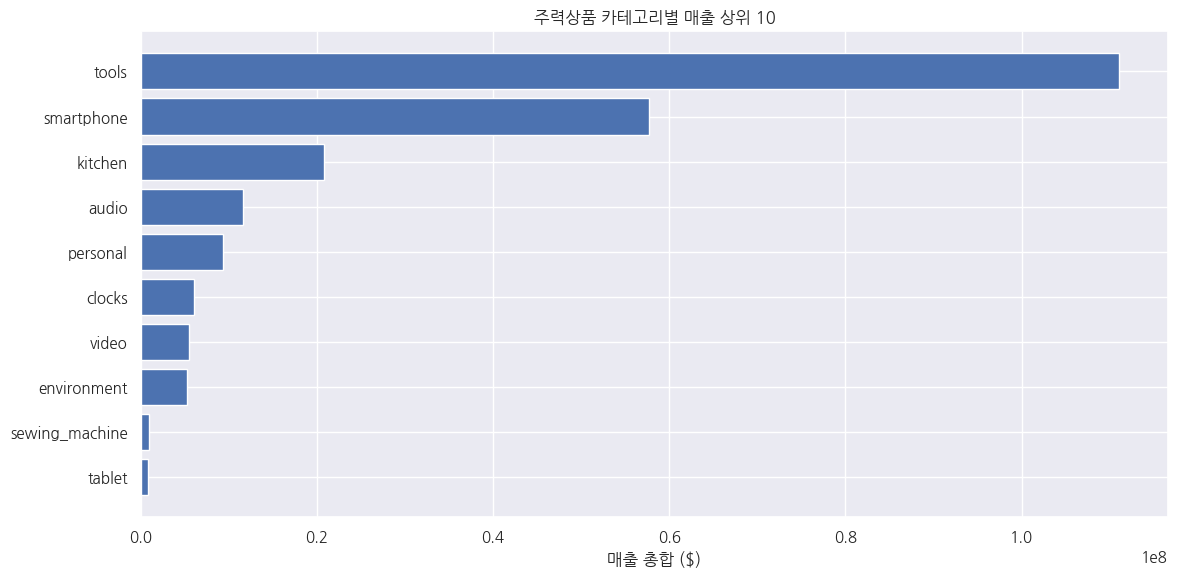

In [ ]:
# 4. 카테고리별 매출 총합 (category_lvl2 기준)
category_revenue = purchase_df.groupby('category_lvl2')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl2'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 카테고리 레벨 3 매출 상위 10

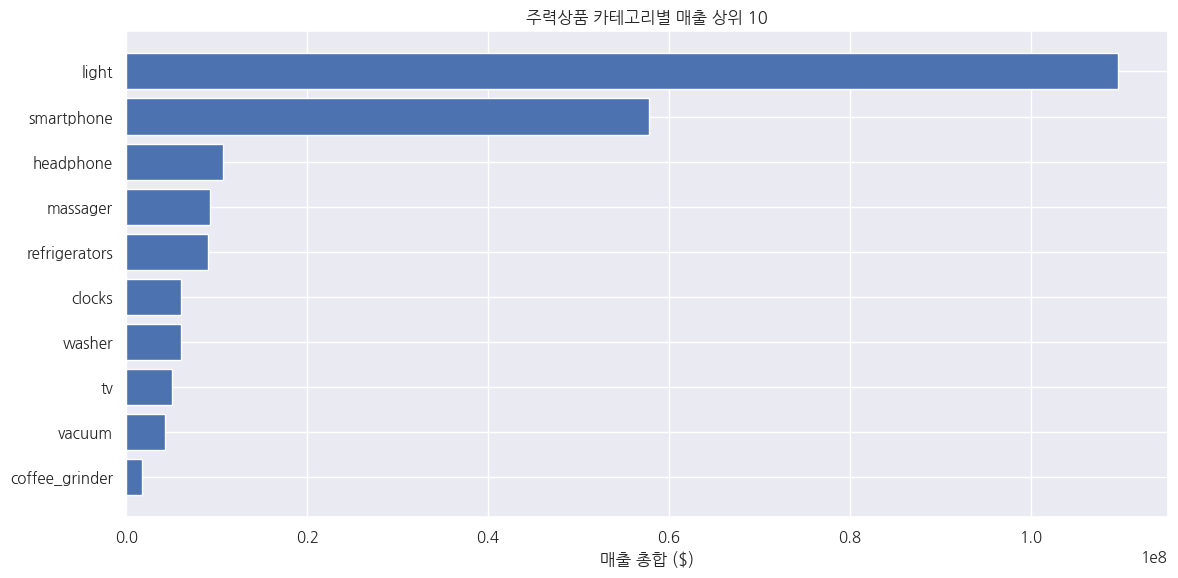

In [ ]:
# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 가격 구간별 구매율

In [ ]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
top_one_df['price_bin'] = pd.cut(top_one_df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = top_one_df[top_one_df['event_type'] == 'purchase']
view_df = top_one_df[top_one_df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 구매율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 구매율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
print(price_group_stats)


  price_bin  purchase_count  view_count  conversion_rate
0     0~100          112691     5570977         0.020228
1   100~200          214648     6502607         0.033010
2   200~300          136385     4408266         0.030938
3   300~400           55423     2360526         0.023479
4   400~500           36406     1532826         0.023751
5  500~1000           97218     3810020         0.025516
6     1000+           37388     1524863         0.024519


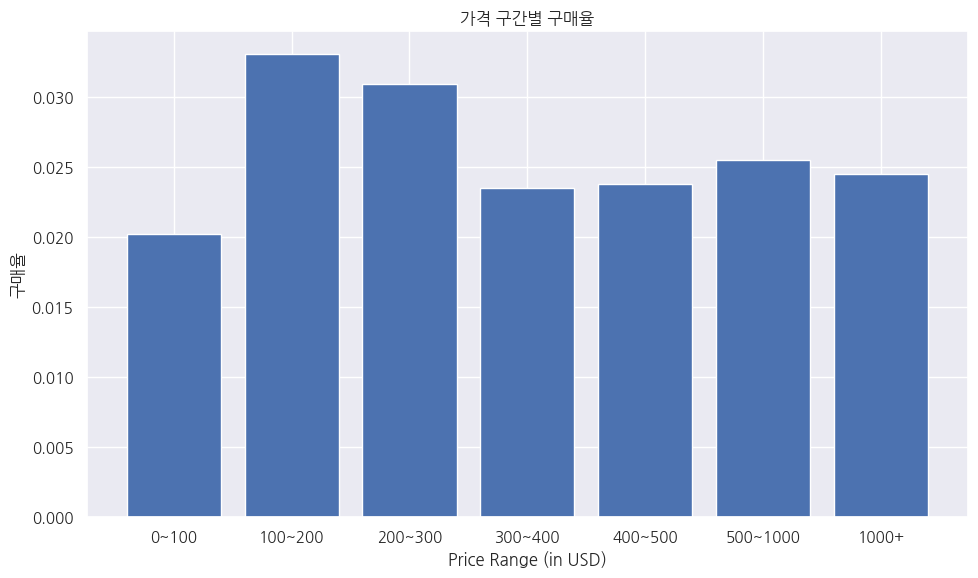

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 구매율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('구매율')
plt.tight_layout()
plt.show()

| 전략 대상                   | 제안                                             |
| ----------------------- | ---------------------------------------------- |
| `appliances > toster`   | 자동 리필, 할인 푸시, 구매 간격 기반 알림                      |
| `microwave`, `massager` | 빠른 구매 결정 → **리뷰 기반 맞춤 추천** 또는 **상세 리뷰 강화**     |
| `welding`               | 관심도는 높으나 구매 이탈 많음 → **가격 장벽 해소**, **체험 리뷰 강조** |
